# Introduction

## Bias a priori

*When implementing an AI system, fairness and biases must be an important component during conception, especially when dealing with sensitive information, and/or Personally Identifiable Information (PII), and/or Personal Health Information (PHI). Indeed, not only those information are bound to the law (e.g., GDPR in Europe), but they are also bound to a brand image challenge.*

Today's example aims at **assigning a risk with recruitment data**.

Before implementing any AI system to predict the likelihood of a candidate to be hired, **AI engineers AND business stakeholders** should:

- Sit and identify potential sources of biases
- Define one or several metrics that will quantify the bias of the AI system

## Dataset

StackOverflow's annual user-generated survey (over 70,000 responses from over 180 countries) of developers examines all aspects of the developer experience, from learning code to preferred technologies, version control and work experience.

From the survey results, we have built a dataset with the following columns:
- **Age**: age of the applicant, >35 years old or <35 years old *(categorical)*
- **EdLevel**: education level of the applicant (Undergraduate, Master, PhD...) *(categorical)*
- **Gender**: gender of the applicant, (Man, Woman, or NonBinary) *(categorical)*
- **MainBranch**: whether the applicant is a profesional developer *(categorical)*
- **YearsCode**: how long the applicant has been coding *(integer)*
- **YearsCodePro**: how long the applicant has been coding in a professional context, *(integer)*
- **PreviousSalary**: the applicant's previous job salary *(float)*
- **ComputerSkills**: number of computer skills known by the applicant *(integer)*
- **Employed**: target variable, whether the applicant has been hired *(categorical)*


## Fairness performance

To facilitate the development of a responsible model, we use the dalex python package: https://dalex.drwhy.ai/


Quoting Dalex' tutorial:


> The idea is that ratios between scores of privileged and unprivileged metrics should be close to 1. The closer, the fairer. To relax this criterion a little bit, it can be written more thoughtfully:

> $$ \forall i \in \{a, b, ..., z\}, \quad \epsilon < \frac{metric_i}{metric_{privileged}} < \frac{1}{\epsilon}.$$

> Where the epsilon is a value between 0 and 1, it should be a minimum acceptable value of the ratio. On default, it is 0.8, which adheres to four-fifths rule (80% rule) often looked at in hiring, for example.
"

##### Metrics used

Description of the metrics used for the fairness performance evaluation of each strategys:



- **Equal opportunity ratio** computed from True positive rate (recall)

> This number describes the proportions of correctly classified positive instances.

> $TPR = \frac{TP}{P}$

- **Predictive parity ratio** computed from Positive predicted value (precision)

> This number describes the ratio of samples which were correctly classified as positive from all the positive predictions.

> $PPV = \frac{TP}{TP + FP}$

- **Accuracy equality ratio** computed from Accuracy

> This number is the ratio of the correctly classified instances (positive and negative) of all decisions.

> $ACC = \frac{TP + TN}{TP + FP + TN + FN}$

- **Predictive equality ratio** computed from False positive rate

> This number describes the share the proportion of actual negatives which was falsely classified as positive.

> $FPR = \frac{FP}{TP + TN}$

- **Statistical parity ratio** computed from Positive rate

> This number is the overall rate of positively classified instances, including both correct and incorrect decisions.

> $PR = \frac{TP + FP}{TP + FP + TN + FN}$

**Notes**:
1. Fairness metrics work the exact same way as performance metrics do. If one was to fit a model on the entire dataset and foster overfitting (namely, skipping a `train_test_split` operation), she would end up with a non biased model.
2. A lots of metrics can be computed. It is important to define early in the conception which are the critical metrics to monitor

The method `model_fairness` returns a fairness object from which fairness evaluations can be conducted. Notice that every metrics inherited from the confusion matrix are computed during the instantiation.

Two methods can then be performed:
- The `fairness_check` method, which returns a report on the fairness of the model. It requires an epsilon parameter that corresponds to the threshold ratio below which a given metric is considered to be unfair (default value is 0.8).
- The `plot` method, which allows to visualize the main fairness ratios between the protected subgroups and the privileged one.

Installing dalex before

In [ ]:
pip install dalex

Importation of modules and libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic
from wordcloud import WordCloud
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
import dalex as dx
import numpy as np
from copy import copy
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import mean_squared_error

# 0 - Data exploration and bias identification





In [ ]:
from google.colab import files
# Use the files.upload() function to upload a file
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
# Read the CSV file into a DataFrame
df = pd.read_csv(file_name, index_col="Unnamed: 0")

Saving stackoverflow_full.csv to stackoverflow_full (2).csv


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73462 entries, 0 to 73461
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             73462 non-null  object 
 1   Accessibility   73462 non-null  object 
 2   EdLevel         73462 non-null  object 
 3   Employment      73462 non-null  int64  
 4   Gender          73462 non-null  object 
 5   MentalHealth    73462 non-null  object 
 6   MainBranch      73462 non-null  object 
 7   YearsCode       73462 non-null  int64  
 8   YearsCodePro    73462 non-null  int64  
 9   Country         73462 non-null  object 
 10  PreviousSalary  73462 non-null  float64
 11  HaveWorkedWith  73399 non-null  object 
 12  ComputerSkills  73462 non-null  int64  
 13  Employed        73462 non-null  int64  
dtypes: float64(1), int64(5), object(8)
memory usage: 8.4+ MB


In [ ]:
df.head()

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,7,4,Sweden,51552.0,C++;Python;Git;PostgreSQL,4,0
1,<35,No,Undergraduate,1,Man,No,Dev,12,5,Spain,46482.0,Bash/Shell;HTML/CSS;JavaScript;Node.js;SQL;Typ...,12,1
2,<35,No,Master,1,Man,No,Dev,15,6,Germany,77290.0,C;C++;Java;Perl;Ruby;Git;Ruby on Rails,7,0
3,<35,No,Undergraduate,1,Man,No,Dev,9,6,Canada,46135.0,Bash/Shell;HTML/CSS;JavaScript;PHP;Ruby;SQL;Gi...,13,0
4,>35,No,PhD,0,Man,No,NotDev,40,30,Singapore,160932.0,C++;Python,2,0


In [ ]:
cat=["Age","Accessibility","EdLevel","Gender","MentalHealth","MainBranch"]
num=["YearsCode","YearsCodePro","PreviousSalary","ComputerSkills"]

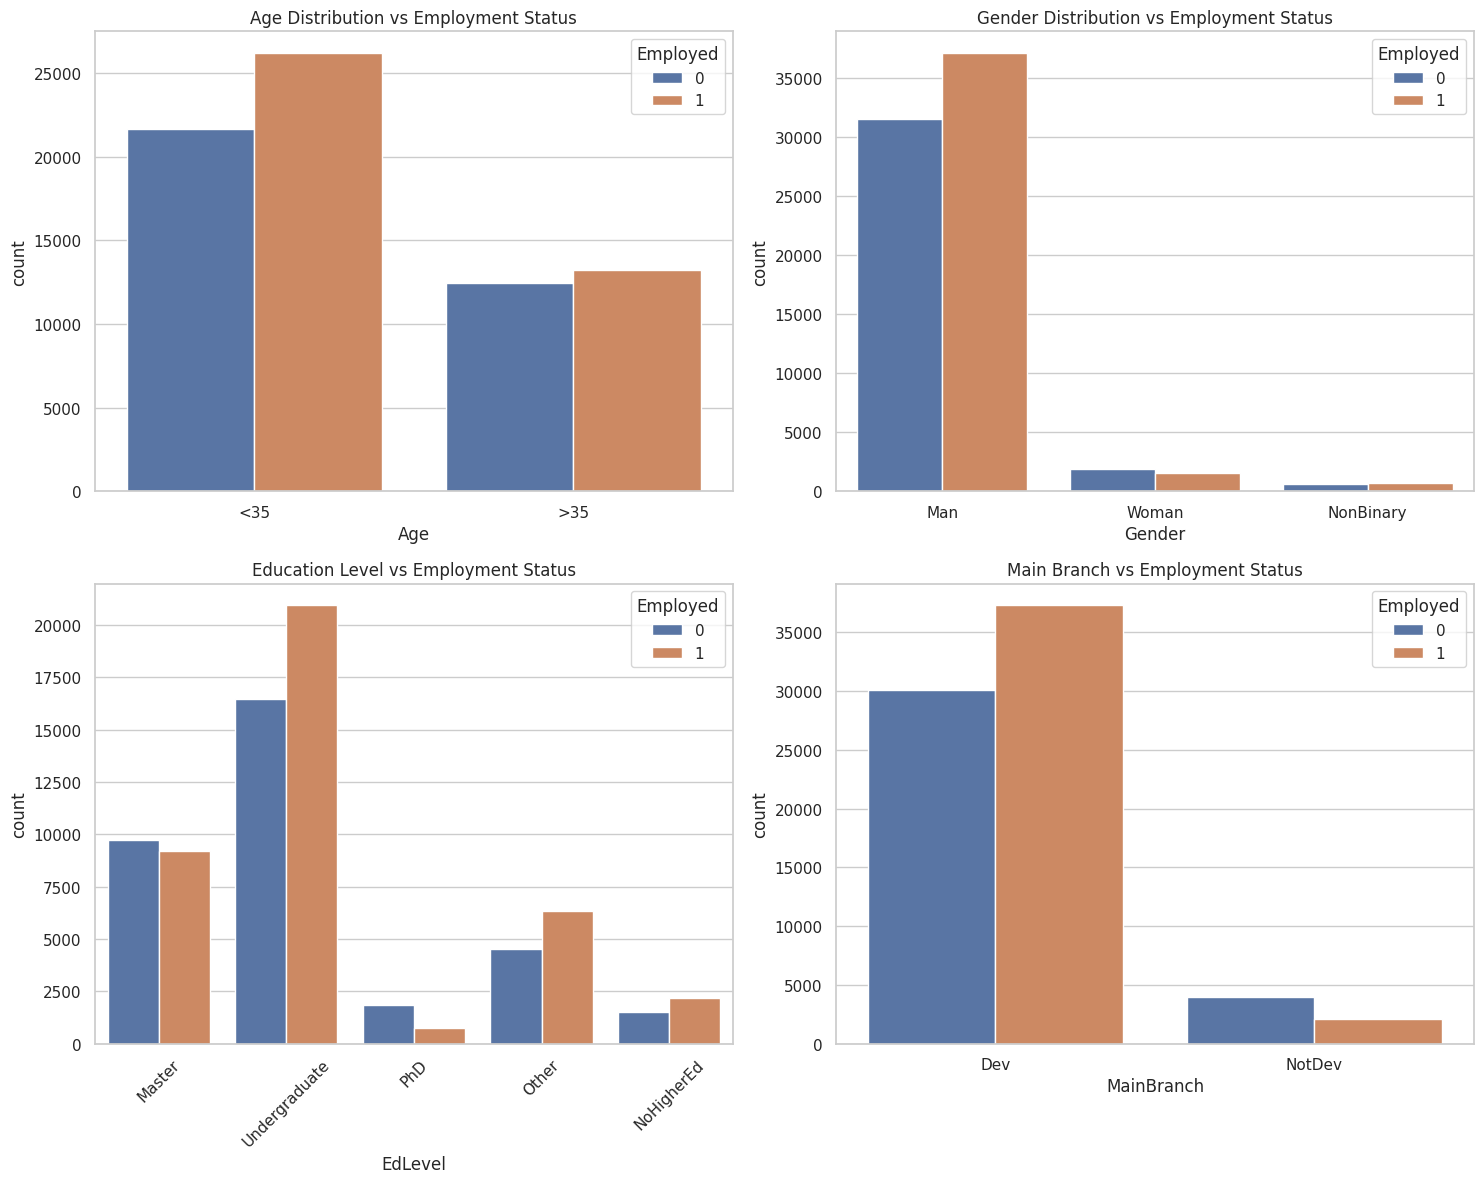

In [ ]:
# Setting up the visualisation settings
sns.set(style="whitegrid")

# Plotting distributions of key demographic columns and their relationship with the 'Employed' status
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Age vs Employed
sns.countplot(x='Age', hue='Employed', data=df, ax=axes[0, 0])
axes[0, 0].set_title('Age Distribution vs Employment Status')

# Gender vs Employed
sns.countplot(x='Gender', hue='Employed', data=df, ax=axes[0, 1])
axes[0, 1].set_title('Gender Distribution vs Employment Status')

# Education Level (EdLevel) vs Employed
sns.countplot(x='EdLevel', hue='Employed', data=df, ax=axes[1, 0])
axes[1, 0].set_title('Education Level vs Employment Status')
axes[1, 0].tick_params(axis='x', rotation=45)

# MainBranch vs Employed
sns.countplot(x='MainBranch', hue='Employed', data=df, ax=axes[1, 1])
axes[1, 1].set_title('Main Branch vs Employment Status')

plt.tight_layout()
plt.show()

(<Figure size 640x480 with 3 Axes>,
 {('0', 'No'): (0.0, 0.0, 0.46146984172004324, 0.7826567736738999),
  ('0', 'Yes'): (0.0,
   0.7859790328101124,
   0.46146984172004324,
   0.21402096718988747),
  ('1', 'No'): (0.46644496609815267,
   0.0,
   0.5335550339018473,
   0.7638530919140368),
  ('1', 'Yes'): (0.46644496609815267,
   0.7671753510502494,
   0.5335550339018473,
   0.2328246489497505)})

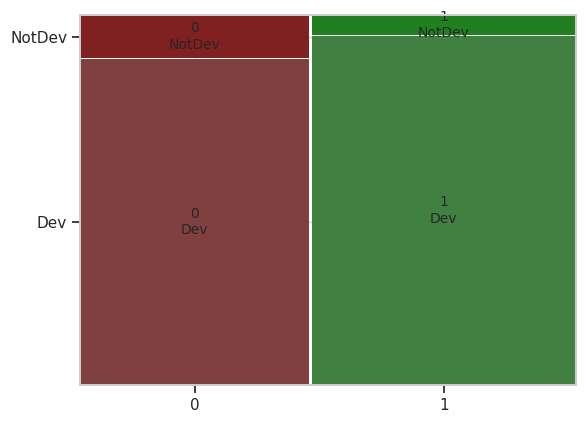

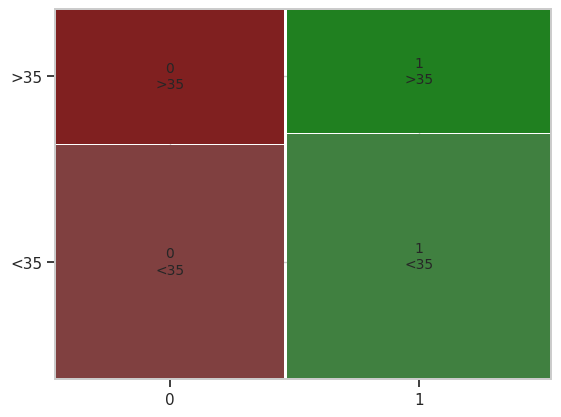

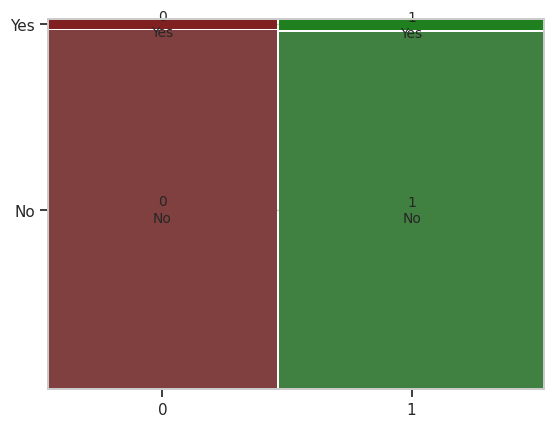

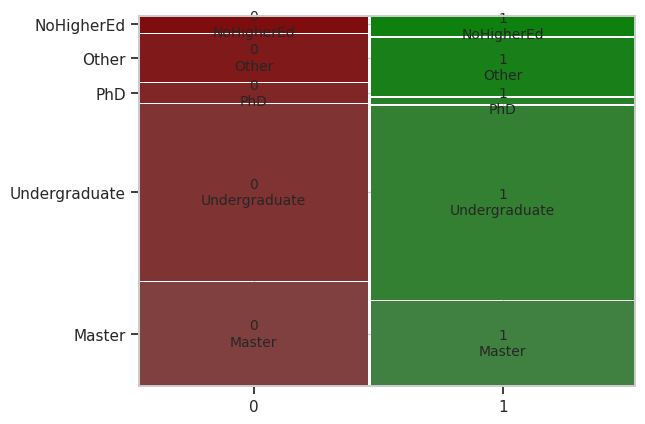

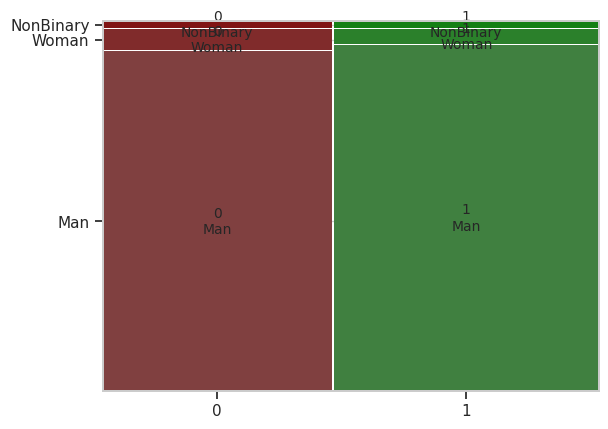

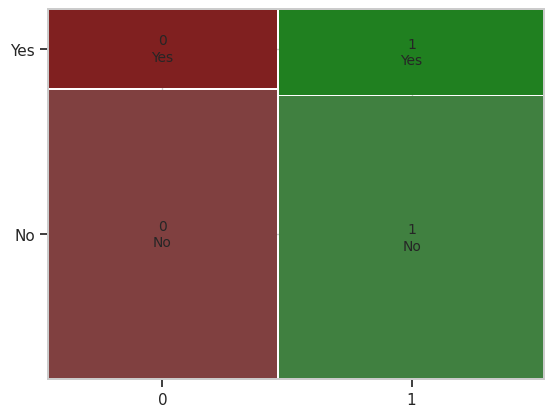

In [ ]:
mosaic(df, index=["Employed","MainBranch"])
mosaic(df, index=["Employed","Age"])
mosaic(df, index=["Employed","Accessibility"])
mosaic(df, index=["Employed","EdLevel"])
mosaic(df, index=["Employed","Gender"])
mosaic(df, index=["Employed","MentalHealth"])

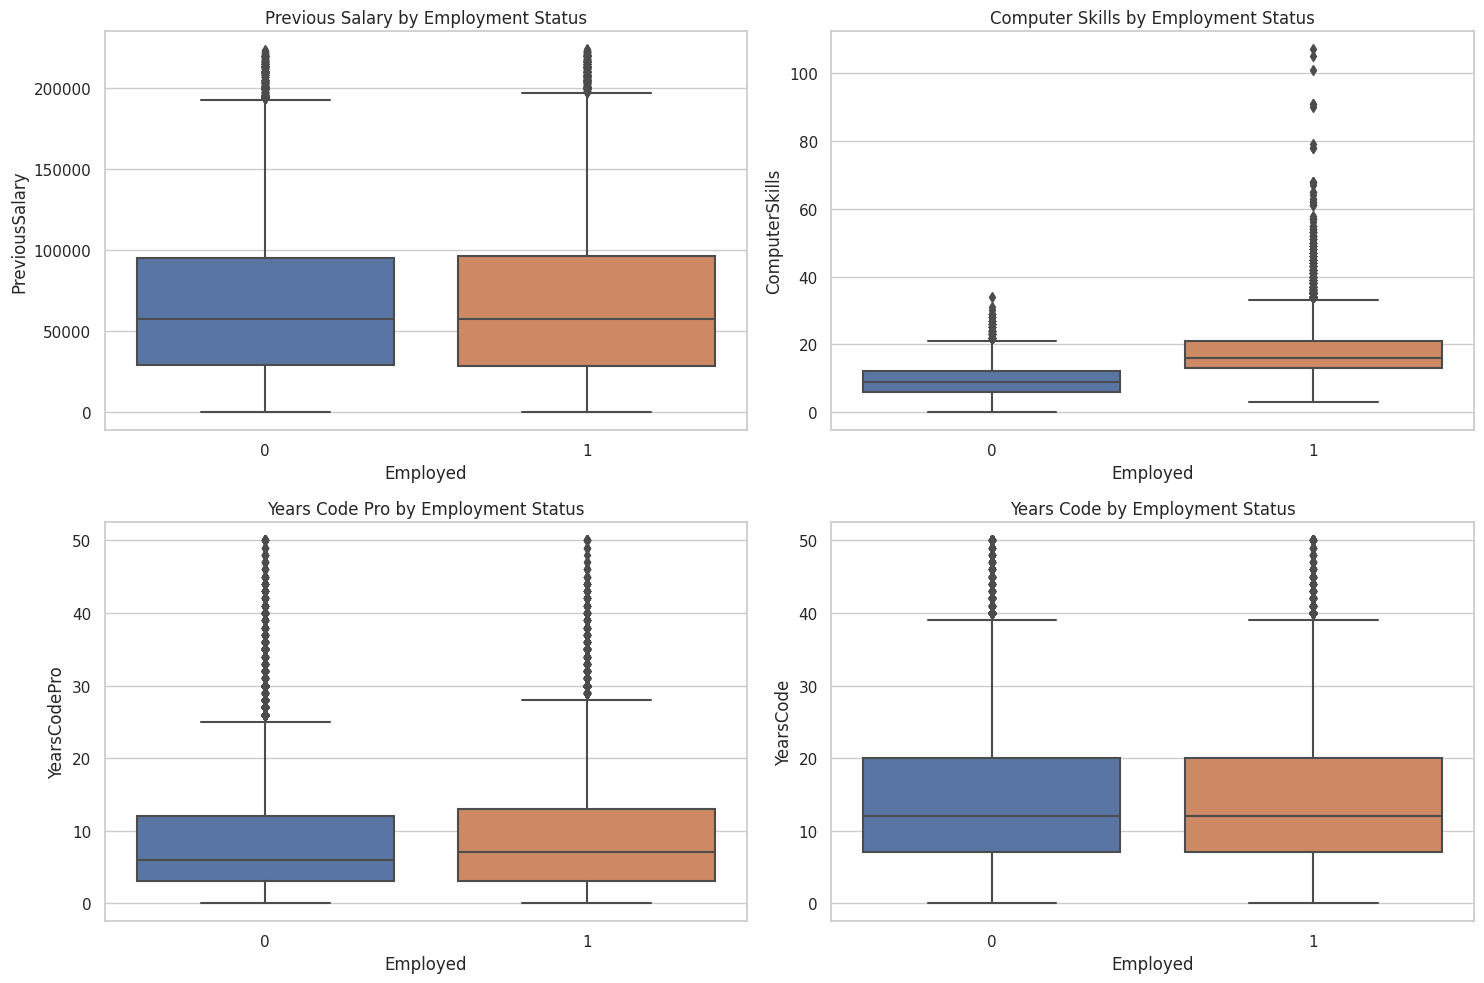

In [ ]:
# Setting the style for the plots
sns.set(style='whitegrid')

# Creating a figure with subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Creating boxplots for each variable
sns.boxplot(ax=axes[0, 0], x="Employed", y="PreviousSalary", data=df)
axes[0, 0].set_title('Previous Salary by Employment Status')

sns.boxplot(ax=axes[0, 1], x="Employed", y="ComputerSkills", data=df)
axes[0, 1].set_title('Computer Skills by Employment Status')

sns.boxplot(ax=axes[1, 0], x="Employed", y="YearsCodePro", data=df)
axes[1, 0].set_title('Years Code Pro by Employment Status')

sns.boxplot(ax=axes[1, 1], x="Employed", y="YearsCode", data=df)
axes[1, 1].set_title('Years Code by Employment Status')

# Adjust layout
plt.tight_layout()
plt.show()

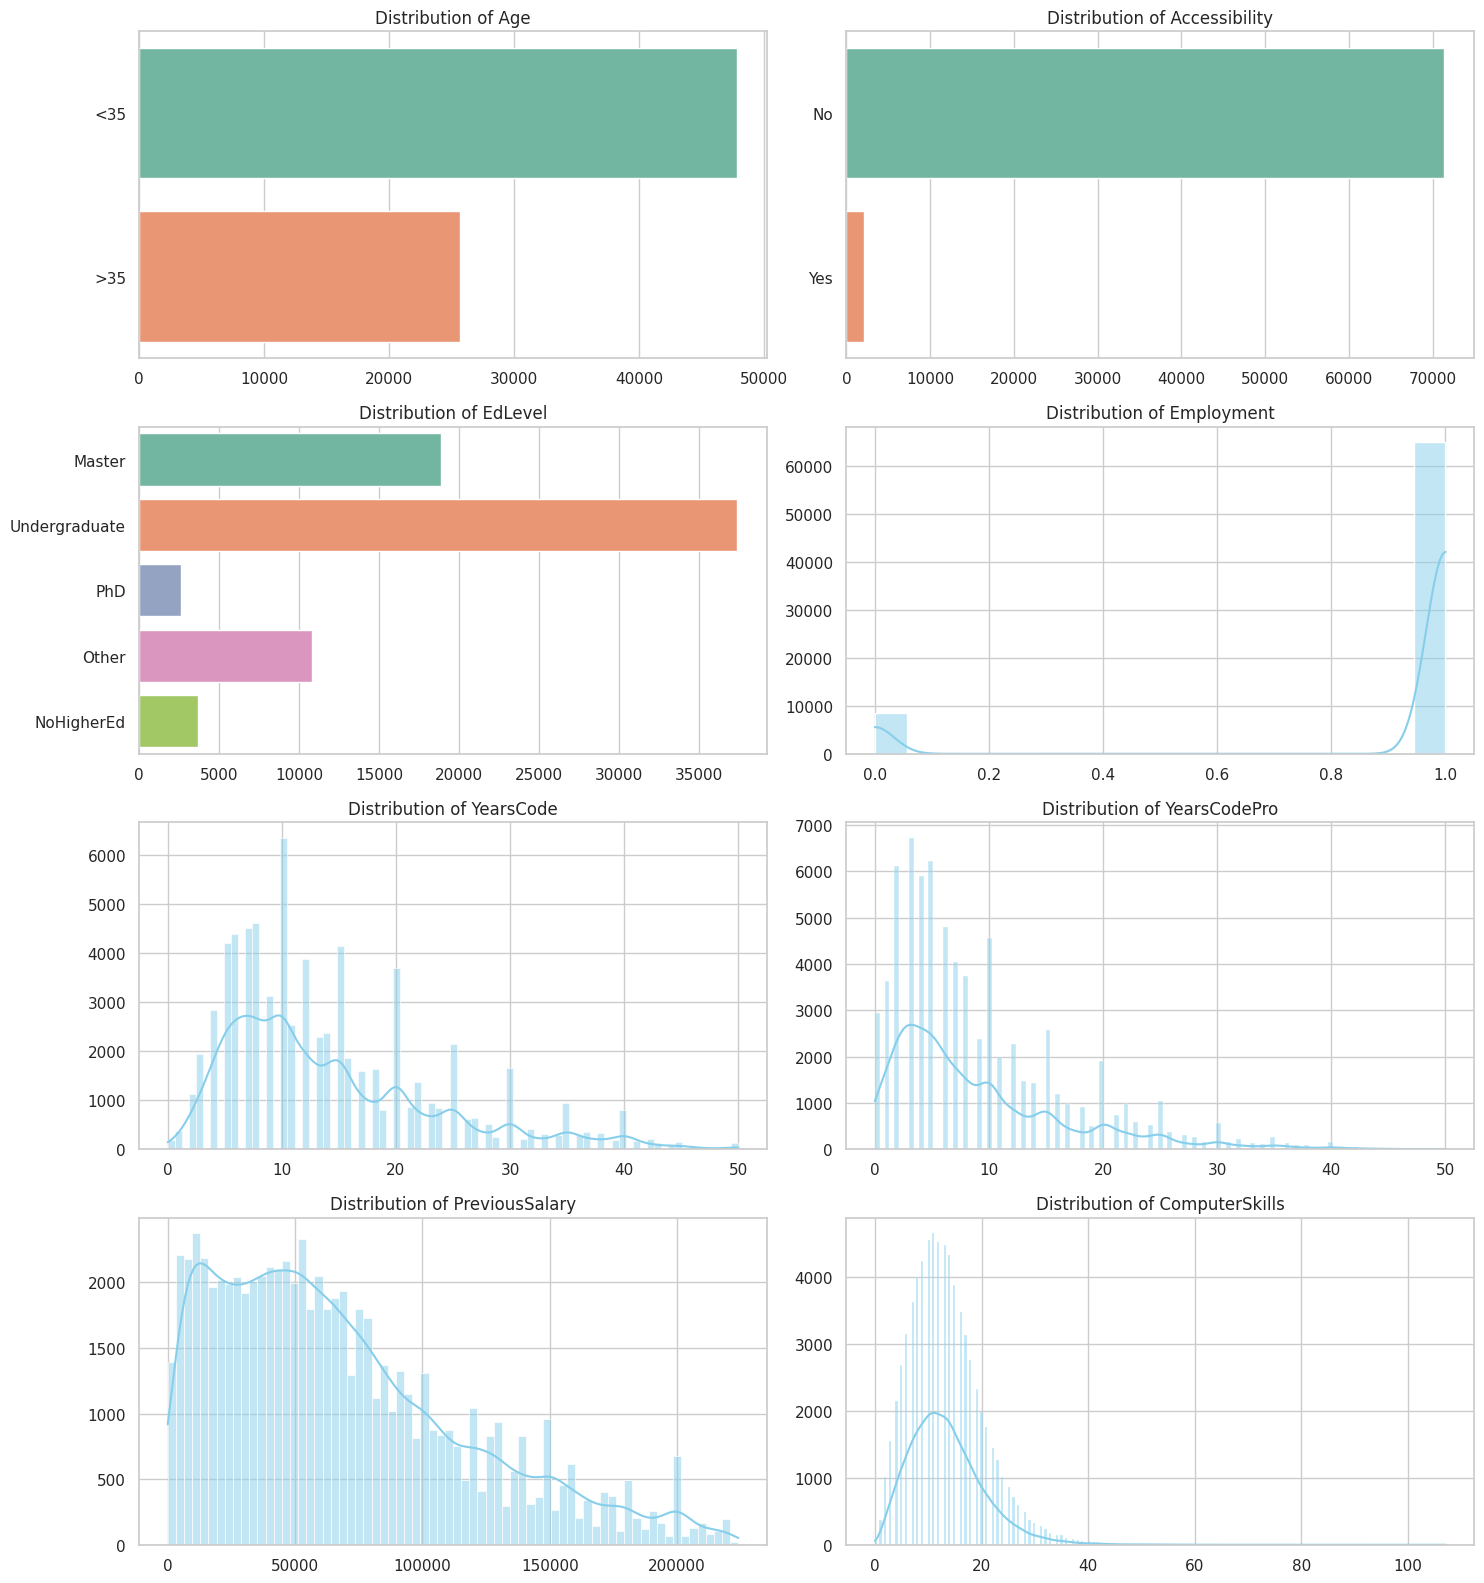

In [ ]:
# Selecting a subset of columns for the summary visualization
# Including both categorical and numerical columns
selected_columns = ['Age', 'Accessibility', 'EdLevel', 'Employment', 'YearsCode', 'YearsCodePro', 'PreviousSalary', 'ComputerSkills']

# Determining the number of rows and columns for the subplot grid
num_cols = len(selected_columns)
nrows = num_cols // 2 if num_cols % 2 == 0 else (num_cols // 2) + 1

# Creating the combined visualization
fig, axes = plt.subplots(nrows, 2, figsize=(15, nrows * 4))

for i, col in enumerate(selected_columns):
    ax = axes[i // 2, i % 2]
    if df[col].dtype == 'object' or col == 'Employed':
        # For categorical columns
        sns.countplot(y=col, data=df, ax=ax, palette='Set2')
    else:
        # For numerical columns
        sns.histplot(df[col], ax=ax, kde=True, color='skyblue')
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel('')
    ax.set_ylabel('')

# Adjust layout
plt.tight_layout()
plt.show()


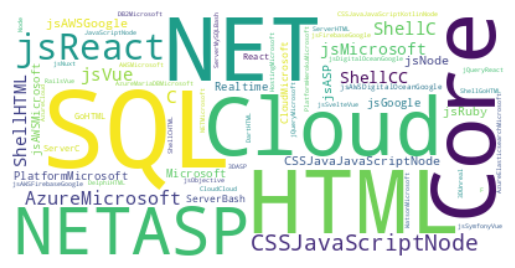

In [ ]:
# Working with HaveWorkedWith before dropping the column
x=[str(cat).split(";") for cat in df["HaveWorkedWith"]]
text = [item for sublist in x for item in sublist]
textf="".join(cat for cat in text)

# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(textf)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Baseline Model

In [ ]:
preprocess = make_column_transformer(
    (StandardScaler(), num),
    (OneHotEncoder(), cat))
X1=df[['Age', 'Accessibility', 'EdLevel', 'Gender', 'MentalHealth', 'MainBranch','YearsCode', 'YearsCodePro', 'PreviousSalary', 'ComputerSkills']]
y1=df['Employed']

X1_train, X1_test, y1_train, y1_test=train_test_split(X1, y1, test_size = 0.25, random_state = 4)

In [ ]:
#With original sample
#Logistic regression
cv_lr1 = make_pipeline(
    preprocess,
    LogisticRegression(penalty = 'l2'))
cv_lr1.fit(X1_train, y1_train)

#Decision Tree
cv_tree1 = make_pipeline(preprocess, DecisionTreeClassifier(max_depth=7, random_state=123))
cv_tree1.fit(X1_train, y1_train)

#Random Forest
cv_forest1 = make_pipeline(preprocess, RandomForestClassifier(n_estimators=200, max_depth=7, random_state=123))
cv_forest1.fit(X1_train, y1_train)

#XGBoost
cv_xg1 = make_pipeline(preprocess,xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=3, learning_rate=0.1, n_estimators=100))
cv_xg1.fit(X1_train, y1_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['YearsCode', 'YearsCodePro',
                                                   'PreviousSalary',
                                                   'ComputerSkills']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Age', 'Accessibility',
                                                   'EdLevel', 'Gender',
                                                   'MentalHealth',
                                                   'MainBranch'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None, num_class=3,
                               num_parallel_tree=None, ...))])

Performance and fairness check

In [ ]:
# Create an Explainer for the Pipeline
exp_tree1 = dx.Explainer(cv_tree1, X1_test, y1_test, verbose=False)
exp_forest1 = dx.Explainer(cv_forest1, X1_test, y1_test, verbose=False)
exp1 = dx.Explainer(cv_lr1, X1_test, y1_test, label='Logistic regression Pipeline')
exp_xg1=dx.Explainer(cv_xg1, X1_test, y1_test, verbose=False)

Preparation of a new explainer is initiated

  -> data              : 18366 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 18366 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Logistic regression Pipeline
  -> predict function  : <function yhat_proba_default at 0x7d726c619b40> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00845, mean = 0.537, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.998, mean = -0.00391, max = 0.951
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
# Model Performance
pd.concat([exp.model_performance().result for exp in [exp1, exp_tree1, exp_forest1,exp_xg1]])

,recall,precision,f1,accuracy,auc
Logistic regression Pipeline,0.797387,0.796168,0.796777,0.783023,0.871296
DecisionTreeClassifier,0.829131,0.775762,0.801559,0.781008,0.866988
RandomForestClassifier,0.822701,0.780932,0.801272,0.782315,0.864049
XGBClassifier,0.827600,0.782172,0.804245,0.785092,0.871589


In [ ]:
# Variable Importance
exp_tree1.model_parts().plot(objects=[exp_forest1.model_parts(), exp1.model_parts(),exp_xg1.model_parts()])

In [ ]:
# Preparation to Test Fairness
protected = X1_test.Gender
mf_tree1 = exp_tree1.model_fairness(protected=protected,
                                  privileged = "Woman")

mf_forest1 = exp_forest1.model_fairness(protected=protected,
                                  privileged = "Woman")

mf_log1 = exp1.model_fairness(protected=protected,
                                  privileged = "Woman")
mf_xg1=exp_xg1.model_fairness(protected=protected,
                                  privileged = "Woman")

In [ ]:
mf_tree1.fairness_check()
mf_forest1.fairness_check()
mf_log1.fairness_check()
mf_xg1.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Woman'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                TPR       ACC       PPV       FPR       STP
Man        1.089005  1.000000  1.031873  1.349515  1.257642
NonBinary  1.109948  1.003841  1.010624  1.383495  1.257642
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Woman'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                TPR       ACC       PPV       FPR       STP
Man        1.089828  0.997449  1.024902  1.381443  1.267857
NonBinary  1.126816  1.014031  1.013106  1.376289  1.272321
Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceed

In [ ]:
mf_tree1.plot(objects=[mf_log1, mf_forest1,mf_xg1],
             type="performance_and_fairness",
             fairness_metric="FPR",
             performance_metric="accuracy")

In [ ]:
john = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['Man'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[4],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['John'])
mary = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['Woman'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[4],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['Mary'])
jean = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['NonBinary'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[4],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['Jean'])

In [ ]:
#bd_john = exp_xg1.predict_parts(john, type='break_down', label=john.index[0])
#bd_mary = exp_xg1.predict_parts(mary, type='break_down', label=mary.index[0])
#bd_jean = exp_xg1.predict_parts(jean, type='break_down', label=jean.index[0])
#bd_interactions_john = exp_xg1.predict_parts(john, type='break_down_interactions', label="John+")
#bd_interactions_mary = exp_xg1.predict_parts(mary, type='break_down_interactions', label="Mary+")
#bd_interactions_jean = exp_xg1.predict_parts(jean, type='break_down_interactions', label="Jean+")
sh_john = exp_xg1.predict_parts(john, type='shap', B = 10, label=john.index[0])
sh_mary = exp_xg1.predict_parts(mary, type='shap', B = 10, label=mary.index[0])
sh_jean = exp_xg1.predict_parts(jean, type='shap', B = 10, label=jean.index[0])

In [ ]:
sh_john.plot(bar_width = 16)

In [ ]:
sh_mary.plot(bar_width = 16)

In [ ]:
sh_jean.plot(bar_width = 16)

# 1 - Think of a solution to pass by those bias

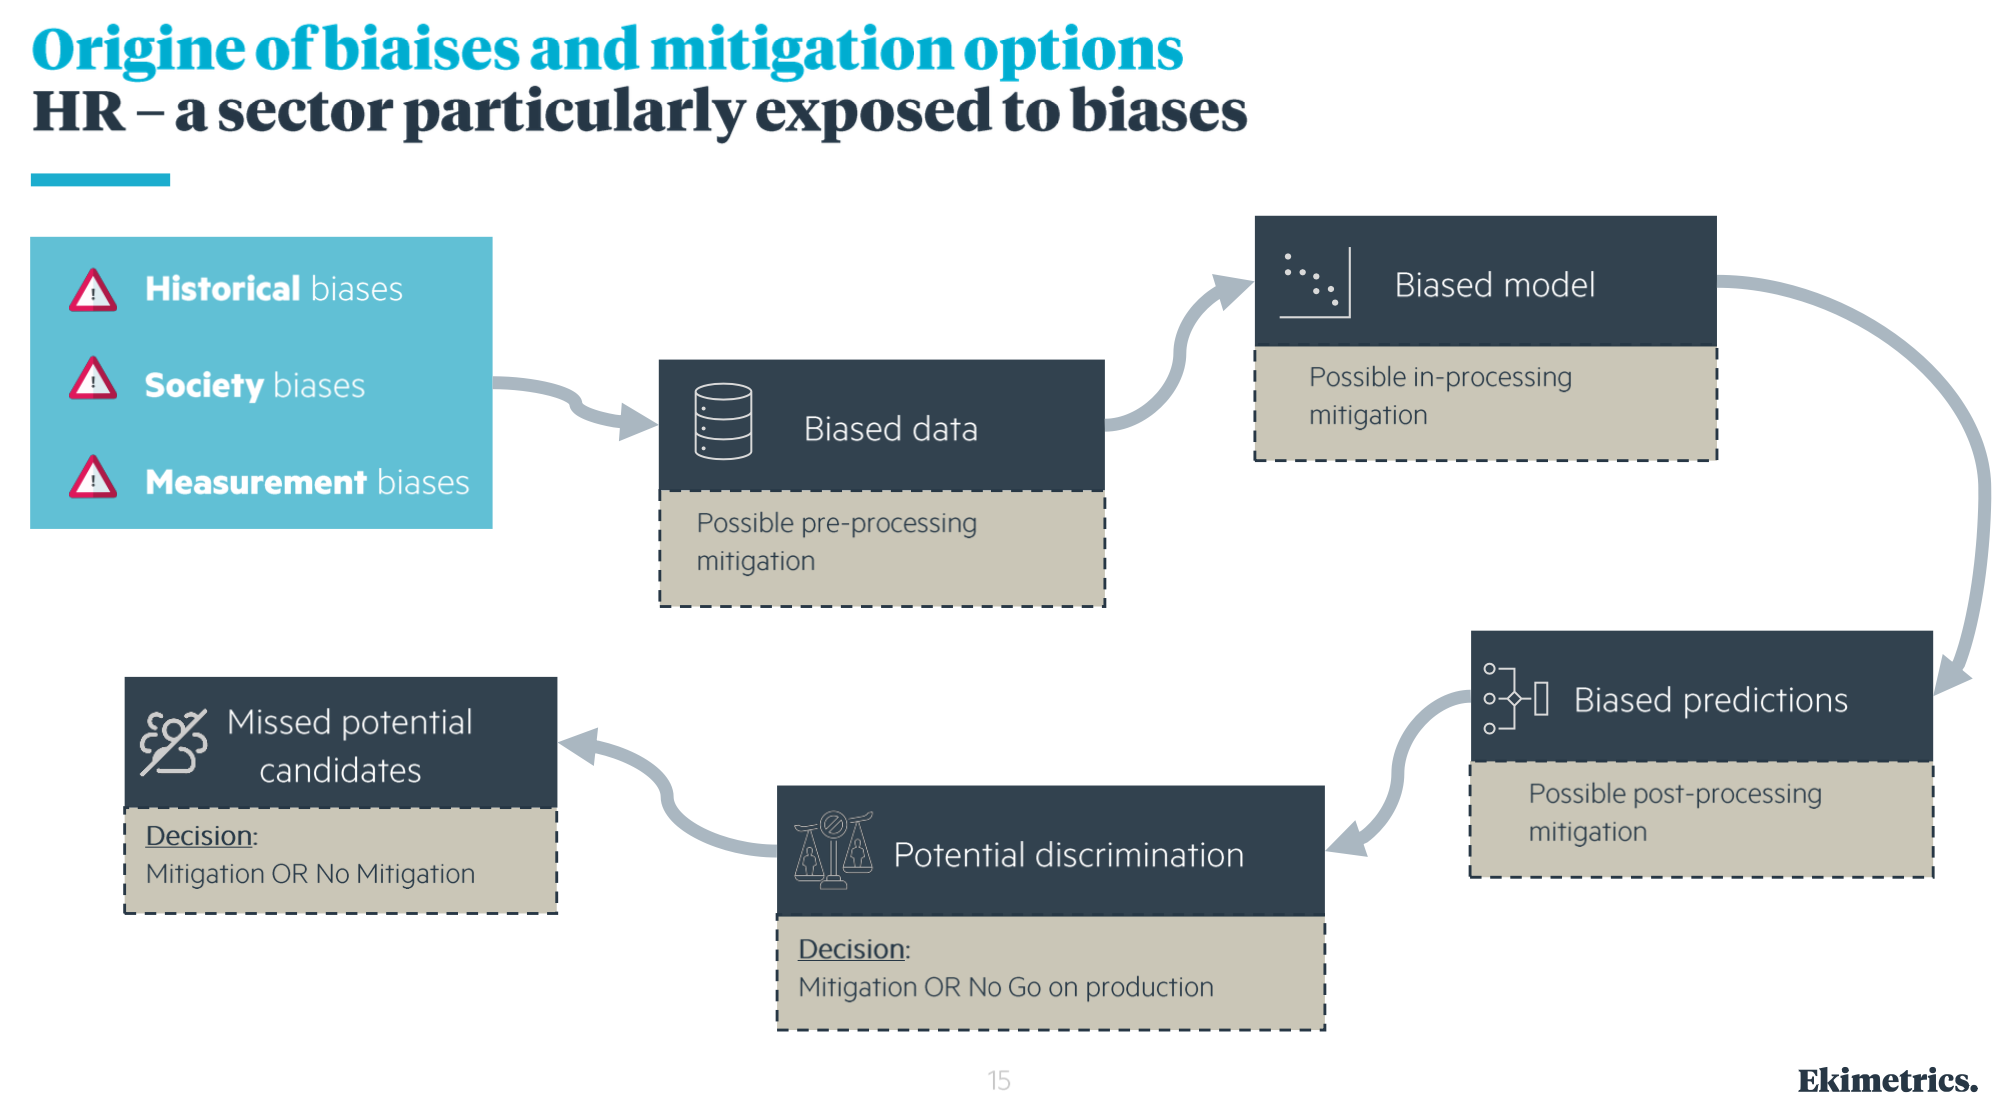

### Addressing Historical, Society, and Measurement Biases
- **Historical Biases**: Update datasets with more recent information or use techniques to re-balance the data.
- **Society Biases**: Develop awareness programs and revise recruitment processes to be more objective and inclusive.
- **Measurement Biases**: Ensure a diverse and representative sample and use multiple data sources.


*Even if we do address the bias, we will still have some in our process. To address it we thought, using the diagram you provided, of the following things to do:*


### Pre-processing Mitigation
- **Data Cleaning**: Handle missing values and errors that may affect certain groups.
- **Feature Selection**: Choose features that do not include proxy variables for protected attributes.
- **Re-sampling or Re-weighting**: Balance the dataset by oversampling underrepresented groups.



### In-processing Mitigation
- **Algorithm Selection**: Choose algorithms less sensitive to imbalances.
- **Incorporate Fairness Constraints**: Modify algorithms to include fairness during training.
- **Validation**: Use cross-validation to ensure fair performance across subgroups.

### Post-processing Mitigation
- **Adjust Decision Thresholds**: Equalize false positives and negatives across groups.
- **Calibration**: Adjust predictions to ensure consistency.
- **Outcome Analysis**: Analyze decisions for fairness before finalizing them.


### Decision Points
- **Post Pre-processing**: Determine the adequacy of bias mitigation before training.
- **Post Predictions**: Decide on model deployment based on fairness analysis (we will do it in the section 2-).

### Monitoring and Feedback
- **Monitor Outcomes**: Evaluate hiring outcomes for any signs of bias.
- **Collect Feedback**: Implement feedback loops from candidates and employees.

*Integrating these solutions into the recruitment pipeline can significantly reduce the biases identified in the dataset, ensuring a fairer hiring process.*

# 2 - Implement the solution and challenge it

### Pre-processing Mitigation



In [ ]:

# DATA CLEANING
# Done in the data exploration

# FEATURE SELECTION
# Removing features that might be proxies for protected attributes (like 'Country' if it's a proxy for ethnicity)
#df = df.drop(['Country'], axis=1)

# RE-WEIGHTING
# Identify the target variable
target_column = 'Employed'

# Separate the dataset into majority and minority classes based on the target variable
majority_class = df[df[target_column] == df[target_column].mode()[0]]  # Most frequent class
minority_class = df[df[target_column] != df[target_column].mode()[0]]  # Less frequent class

# Upsample minority class
minority_upsampled = resample(minority_class,
                              replace=True,      # sample with replacement
                              n_samples=len(majority_class),  # to match majority class
                              random_state=123)  # reproducible results

# Combine majority class with upsampled minority class
upsampled_data = pd.concat([majority_class, minority_upsampled])

# Shuffle the data to avoid any order bias
upsampled_data = upsampled_data.sample(frac=1, random_state=123).reset_index(drop=True)

# The 'upsampled_data' is now a balanced dataset
upsampled_data.head()

,Age,Accessibility,EdLevel,Employment,Gender,MentalHealth,MainBranch,YearsCode,YearsCodePro,Country,PreviousSalary,HaveWorkedWith,ComputerSkills,Employed
0,<35,No,Master,1,Man,No,Dev,16,10,India,49564.0,C;Java;Python;Git;AWS;Microsoft Azure;Elastics...,9,0
1,>35,No,Undergraduate,1,Man,No,Dev,28,26,Germany,74651.0,Bash/Shell;C#;Dart;Go;Groovy;HTML/CSS;Java;Jav...,25,1
2,<35,No,Undergraduate,1,Man,No,Dev,15,6,Japan,89929.0,Clojure;Go;Julia;Scala;Kubernetes;Yarn;Flask;G...,12,0
3,<35,No,Undergraduate,1,Man,No,Dev,17,15,Brazil,74784.0,C#;Dart;Go;JavaScript;Kotlin;Python;SQL;TypeSc...,25,1
4,>35,Yes,Other,1,Man,No,Dev,40,33,United States of America,90000.0,C;C#;HTML/CSS;JavaScript;SQL;Git;ASP.NET;jQuer...,9,1


### In-processing Mitigation

##### Data Preprocessing & Preparation for Modeling

- Use of StandardScaler to normalize numerical variables and OneHotEncoder to transform categorical variables into binary vectors.
- Creation of a column transformer (make_column_transformer) to apply these preprocessings to the appropriate columns.

- Selection of features for learning (X) and the target variable (y).
- Splitting the data into training and test sets (train_test_split).

In [ ]:
X=upsampled_data[['Age', 'Accessibility', 'EdLevel', 'Gender', 'MentalHealth', 'MainBranch','YearsCode', 'YearsCodePro', 'PreviousSalary', 'ComputerSkills']]
y=upsampled_data['Employed']

X_train, X_test, y_train, y_test=train_test_split(X, y, test_size = 0.25, random_state = 4)

##### Creation and Training of Classification Models

- Use of different algorithms (logistic regression, decision tree, random forest, XGBoost) integrated into pipelines to automate the preprocessing and learning flow.

In [ ]:
#With preprocessed sample
#Logistic regression
cv_lr = make_pipeline(
    preprocess,
    LogisticRegression(penalty = 'l2'))
cv_lr.fit(X_train, y_train)

#Decision Tree
cv_tree = make_pipeline(preprocess, DecisionTreeClassifier(max_depth=7, random_state=123))
cv_tree.fit(X_train, y_train)

#Random Forest
cv_forest = make_pipeline(preprocess, RandomForestClassifier(n_estimators=200, max_depth=7, random_state=123))
cv_forest.fit(X_train, y_train)

#XGBoost
cv_xg = make_pipeline(preprocess,xgb.XGBClassifier(objective='multi:softmax', num_class=3, max_depth=3, learning_rate=0.1, n_estimators=100))
cv_xg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['YearsCode', 'YearsCodePro',
                                                   'PreviousSalary',
                                                   'ComputerSkills']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['Age', 'Accessibility',
                                                   'EdLevel', 'Gender',
                                                   'MentalHealth',
                                                   'MainBranch'])])),
                ('xgbclassifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=3, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None, num_class=3,
                               num_parallel_tree=None, ...))])

##### Performance Analysis

- Use of dalex to create model "explainers" that allow for the analysis of performance and variable importance.
- Finding that "ComputerSkills" is the most important feature in all models.

In [ ]:
# Create an Explainer for the Pipeline
exp_tree = dx.Explainer(cv_tree, X_test, y_test, verbose=False)
exp_forest = dx.Explainer(cv_forest, X_test, y_test, verbose=False)
exp = dx.Explainer(cv_lr, X_test, y_test, label='Logistic regression Pipeline')
exp_xg=dx.Explainer(cv_xg, X_test, y_test, verbose=False)

Preparation of a new explainer is initiated

  -> data              : 19696 rows 10 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 19696 values
  -> model_class       : sklearn.linear_model._logistic.LogisticRegression (default)
  -> label             : Logistic regression Pipeline
  -> predict function  : <function yhat_proba_default at 0x7d726c619b40> will be used (default)
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.00768, mean = 0.498, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.999, mean = 0.00643, max = 0.956
  -> model_info        : package sklearn

A new explainer has been created!


In [ ]:
# Model Performance
pd.concat([exp.model_performance().result for exp in [exp, exp_tree, exp_forest,exp_xg]])

,recall,precision,f1,accuracy,auc
Logistic regression Pipeline,0.756825,0.794606,0.775255,0.778838,0.869755
DecisionTreeClassifier,0.789866,0.774956,0.782340,0.778483,0.867564
RandomForestClassifier,0.813539,0.761743,0.786789,0.777772,0.867344
XGBClassifier,0.796615,0.771362,0.783785,0.778483,0.870592


In [ ]:
# Variable Importance
exp_tree.model_parts().plot(objects=[exp_forest.model_parts(), exp.model_parts(),exp_xg.model_parts()])

##### Analysis of Algorithmic Fairness (Fairness)

- Checking the fairness of models by focusing on gender as a protected variable.
- Use of different methods (fairness_check, plot) to evaluate and visualize parity between groups.

In [ ]:
# Preparation to Test Fairness
protected = X_test.Gender
mf_tree = exp_tree.model_fairness(protected=protected,
                                  privileged = "Woman")

mf_forest = exp_forest.model_fairness(protected=protected,
                                  privileged = "Woman")

mf_log = exp.model_fairness(protected=protected,
                                  privileged = "Woman")
mf_xg=exp_xg.model_fairness(protected=protected,
                                  privileged = "Woman")

In [ ]:
mf_tree.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Woman'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                TPR       ACC       PPV       FPR       STP
Man        1.077551  0.970037  1.033289  1.525641  1.360313
NonBinary  1.080272  0.981273  1.029294  1.423077  1.308094


In [ ]:
mf_forest.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Woman'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                TPR       ACC       PPV       FPR       STP
Man        1.057069  0.956843  1.013298  1.625767  1.359102
NonBinary  1.059663  0.965475  1.007979  1.527607  1.311721


In [ ]:
mf_log.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Woman'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                TPR       ACC       PPV       FPR       STP
Man        1.115836  0.970075  1.014031  1.685950  1.431085
NonBinary  1.010264  0.946384  1.007653  1.446281  1.246334


In [ ]:
mf_xg.fairness_check()

Bias detected in 2 metrics: FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on 'Woman'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
                TPR       ACC       PPV       FPR       STP
Man        1.071046  0.960445  1.014455  1.629139  1.375000
NonBinary  1.057641  0.967862  1.014455  1.470199  1.299479


We note that all the classifiers are baised. Let's try to quantify the bias.

In [ ]:
mf_tree.plot(objects=[mf_log, mf_forest, mf_xg])

We see that the bias seem not to be much.

In [ ]:
mf_tree.plot(objects=[mf_log, mf_forest,mf_xg], type='stacked')

The DecisionTreeClassifier seems to have the smallest parity loss.

In [ ]:
mf_tree.plot(objects=[mf_log, mf_forest,mf_xg],
             type="performance_and_fairness",
             fairness_metric="FPR",
             performance_metric="accuracy")

The bigger the accuracy, the greater the parity loss.
Is there any method that would enable us to mitigate bias? Yes, and we will try some in the next section.

##### Bias Mitigation

- Application of techniques such as ceteris paribus cutoff, roc_pivot, resample, reweight to attempt to reduce biases in models.
- Retraining models with these techniques and assessing fairness after mitigation.

**Ceteris Paribus Cutoff**

The "ceteris paribus cutoff" method for mitigating bias in machine learning models involves identifying an optimal decision threshold that balances fairness and performance. This approach adjusts the classification cutoff while keeping other model parameters constant, aiming to minimize disparity in fairness metrics across different groups. It is particularly useful in scenarios where there is a trade-off between model accuracy and the fairness of predictions for protected subgroups.

In [ ]:
mf_tree.plot(objects=[mf_log, mf_forest,mf_xg], type="ceteris_paribus_cutoff", subgroup="Woman")

**ROC Pivot**

This method adjusts the decision threshold based on the Receiver Operating Characteristic (ROC) curve to balance sensitivity and specificity, aiming to improve fairness in predictions while maintaining model performance.

In [ ]:
privileged="Woman"
exp1 = copy(exp)
exp2 = copy(exp_forest)
exp3=copy(exp_tree)
expg=copy(exp_xg)
# roc pivot
exp1 = roc_pivot(exp1, protected, privileged, theta = 0.02, verbose = False)
exp2 = roc_pivot(exp2, protected, privileged, theta = 0.02, verbose = False)
exp3 = roc_pivot(exp3, protected, privileged, theta = 0.02, verbose = False)
expg = roc_pivot(expg, protected, privileged, theta = 0.02, verbose = False)


NameError: ignored

In [ ]:
fobject1 = exp1.model_fairness(protected, privileged, label='roc Logistic')
fobject2 = exp2.model_fairness(protected, privileged, label='roc forest')
fobject3 = exp3.model_fairness(protected, privileged, label='roc tree')
fobjectg = expg.model_fairness(protected, privileged, label='roc xg')

In [ ]:
fobject1.plot([fobject2,fobject3,fobjectg])

In [ ]:
fobjectg.fairness_check()

In [ ]:
fobject1.fairness_check()

In [ ]:
fobject2.fairness_check()

In [ ]:
fobject3.fairness_check()

**Resample**

This approach involves altering the training dataset by oversampling underrepresented groups or undersampling overrepresented groups, thereby creating a more balanced dataset that can lead to fairer model outcomes.

In [ ]:
# copying
clf_u = copy(cv_lr)
clf_p = copy(cv_lr)
clfx=copy(cv_xg)
clfx2=copy(cv_xg)

In [ ]:
indices_uniform = resample(X_test.Gender, y_test, verbose = False)
indices_preferential = resample(X_test.Gender,
                                y_test,
                                type = 'preferential', # different type
                                probs = exp.y_hat, # requires probabilities
                                verbose = False)


clf_u.fit(X_test.iloc[indices_uniform, :], y_test.iloc[indices_uniform])
clf_p.fit(X_test.iloc[indices_preferential, :], y_test.iloc[indices_preferential])
clfx.fit(X_test.iloc[indices_preferential, :], y_test.iloc[indices_preferential])
clfx2.fit(X_test.iloc[indices_uniform, :], y_test.iloc[indices_uniform])


In [ ]:
exp3u = dx.Explainer(clf_u, X_test, y_test, verbose = False)
exp3p = dx.Explainer(clf_p, X_test, y_test, verbose = False)
exp3x = dx.Explainer(clfx, X_test, y_test, verbose = False)
exp3x1 = dx.Explainer(clfx2, X_test, y_test, verbose = False)

In [ ]:
fobject3u = exp3u.model_fairness(protected, privileged, label='res_unif_lr')
fobject3p = exp3p.model_fairness(protected, privileged, label='res_pref_lr')
fobject3xx = exp3x.model_fairness(protected, privileged, label='res_pref_xg')
fobject3x1 = exp3x1.model_fairness(protected, privileged, label='res_unif_xg')

In [ ]:
fobject3u.fairness_check()

In [ ]:
fobject3p.fairness_check()

In [ ]:
fobject3x1.fairness_check()

In [ ]:
fobject3xx.fairness_check()

**Reweight**

This technique adjusts the weights assigned to different samples in the training dataset, giving more importance to underrepresented groups. This helps in reducing bias by ensuring that the model pays more attention to these groups during training.

Logistic regression

In [ ]:
weights = reweight(protected, y_test, verbose = False)

cv_weighted_lr = copy(cv_lr)

kwargs = {cv_weighted_lr.steps[-1][0] + '__sample_weight': weights}

cv_weighted_lr.fit(X_test,y_test, **kwargs)

In [ ]:
expw_lr = dx.Explainer(cv_weighted_lr, X_test, y_test, verbose = False)
fobjectw_lr = expw_lr.model_fairness(protected, privileged, label='weighted')
fobjectw_lr.fairness_check()

In [ ]:
fobject3wp = expw_lr.model_fairness(X_test.Age, '<35', label='weighted')
fobject3wp.fairness_check()

In [ ]:
fobject3wp = expw_lr.model_fairness(X_test.MentalHealth, 'No', label='weighted')
fobject3wp.fairness_check()

In [ ]:
fobject3wp = expw_lr.model_fairness(X_test.Accessibility, 'No', label='weighted')
fobject3wp.fairness_check()

This is much better than before. We decided to try for the Decision Tree and the XGBoost.

Testing with Decision tree

In [ ]:
clf_weighted_forest = copy(cv_forest)

kwargs = {clf_weighted_forest.steps[-1][0] + '__sample_weight': weights}

clf_weighted_forest.fit(X_test,y_test, **kwargs)

In [ ]:
expwt = dx.Explainer(clf_weighted_forest, X_test, y_test, verbose = False)
fobject3wt = expwt.model_fairness(protected, privileged, label='weighted')
fobject3wt.fairness_check()

Testing with xgboost

In [ ]:
clf_weighted_xg = copy(cv_xg)

kwargs = {clf_weighted_xg.steps[-1][0] + '__sample_weight': weights}

clf_weighted_xg.fit(X_test,y_test, **kwargs)

In [ ]:
expxg = dx.Explainer(clf_weighted_xg, X_test, y_test, verbose = False)
fobjectxg = expxg.model_fairness(protected, privileged, label='weighted')
fobjectxg.fairness_check()

In [ ]:
fobjectxg = expxg.model_fairness(X_test.Accessibility, 'No', label='weighted')
fobjectxg.fairness_check()

In [ ]:
fobjectxg = expxg.model_fairness(X_test.MentalHealth, 'No', label='weighted')
fobjectxg.fairness_check()

In [ ]:
fobjectxg = expxg.model_fairness(X_test.Age, '<35', label='weighted')
fobjectxg.fairness_check()

In [ ]:
fobjectxg.plot()

In [ ]:
fobjectxg.plot(objects=[fobject3wt, fobjectw_lr],
               type="performance_and_fairness",
               fairness_metric="FPR",
               performance_metric="accuracy")

So the mitigating the model xgboost with reweighing tends to render it fair with respect to the variables: Age, Gender, Accessibility and Mental Health

##### Detailed Analysis with Dalex

- Use of model_parts, model_performance, and other Dalex tools for a more in-depth analysis.
- Evaluation of the impact of different features on the predictions of the models using techniques such as SHAP and Break Down.

In [ ]:
explanation=expxg.model_parts()
explanation.result
explanation.plot()

In [ ]:
explanationp=exp_xg1.model_parts()
explanationp.result
explanationp.plot()

In [ ]:
mp = expxg.model_performance(model_type = 'classification')
mp.result

In [ ]:
mp.plot(geom="roc")

### Post-processing Mitigation/Evaluation

##### Complementary Analysis

- Use of cross-validation to evaluate the performance of the XGBoost model.
- Analysis of model profiles (PDP, ALE) to understand how different features influence predictions.

In [ ]:
# Perform cross-validation
cv_scores = cross_val_score(cv_xg, X_train, y_train, cv=5, scoring='accuracy')
# Print the cross-validation scores
print("Cross-validation Scores:", cv_scores)
print("Mean Accuracy: {:.2f}".format(cv_scores.mean()))

In [ ]:
param_grid = {
    'xgbclassifier__learning_rate': [0.01, 0.1, 0.2],
    'xgbclassifier__max_depth': [3, 4, 5],
    'xgbclassifier__n_estimators': [50, 100, 200]
}

# Choose a cross-validation strategy, for example, 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Create a pipeline with preprocessing and XGBoost
xgb_model = make_pipeline(preprocess, xgb.XGBClassifier())

# Set up the GridSearchCV with the pipeline
grid_search = GridSearchCV(xgb_model, param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters: ", grid_search.best_params_)

# Evaluate on the test set
y_pred = grid_search.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error on Test Set: ", mse)

In [ ]:
ale_num = expxg.model_profile(type = 'accumulated', label="ale")

In [ ]:
pdp_num = expxg.model_profile(type = 'partial', label="pdp")

In [ ]:
pdp_num.plot(ale_num)

##### Interpretation/Visualisation of our best model (XGBoost)

In [ ]:
john = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['Man'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[4],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['John'])
mary = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['Woman'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[4],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['Mary'])
jean = pd.DataFrame({'Age': '<35',
                       'Accessibility': ['Yes'],
                       'EdLevel': ['PhD'],
                       'Gender': ['NonBinary'],
                       'MentalHealth': ['No'],
                       'MainBranch': ['Dev'],
                       'YearsCode':[4],
                       'YearsCodePro':[7],
                       'PreviousSalary': [60000],
                       'ComputerSkills': [7]
                     },
                      index = ['Jean'])

In [ ]:
#bd_john = expxg.predict_parts(john, type='break_down', label=john.index[0])
#bd_mary1 = expxg.predict_parts(mary, type='break_down', label=mary.index[0])
#bd_jean = expxg.predict_parts(jean, type='break_down', label=jean.index[0])
#bd_interactions_john = expxg.predict_parts(john, type='break_down_interactions', label="John+")
#bd_interactions_mary1 = expxg.predict_parts(mary, type='break_down_interactions', label="Mary+")
#bd_interactions_jean = expxg.predict_parts(jean, type='break_down_interactions', label="Jean+")
sh_john1 = expxg.predict_parts(john, type='shap', B = 10, label=john.index[0])
sh_mary1 = expxg.predict_parts(mary, type='shap', B = 10, label=mary.index[0])
#sh_jean = expxg.predict_parts(jean, type='shap', B = 10, label=jean.index[0])

In [ ]:
bd_john.plot(bd_interactions_john)

In [ ]:
bd_mary1.plot(bd_interactions_mary1)

In [ ]:
sh_mary1.plot(bar_width = 16)

In [ ]:
sh_john1.plot(bar_width = 16)

In [ ]:
sh_jean.plot(bar_width = 16)

# 3 - Thinks of business analytics in our solution

During a recruitment process, whether it be physically or on line, most biases come from human stereotypes ; those may be reproduced in our algorithm , and we've tried to mitigate them by adding some features that seemed relevant to us. The three phases (pre/in/post processing) we've gone through gave us opportunities to actively reduce them.

Our result provide you with an algorithm able to efficiently classify the applicants to a job offer.

**Ethical Recruitment and Corporate Responsibility:** In today's socially conscious business environment, ethical recruitment isn't just a nice-to-have; it's a necessity. Our solution helps your organization lead the way in fair hiring practices. By systematically reducing biases, we're not only promoting equality but also aligning with global corporate responsibility standards. This commitment to ethical recruitment resonates with customers, investors, and potential employees, enhancing your company's reputation as a leader in corporate ethics.

**Enhancing Diversity and Innovation:** A diverse workforce is a key driver of innovation and business success. By minimizing biases in recruitment, our algorithm enables you to tap into a wider talent pool, bringing in a variety of perspectives and skills. This diversity fosters creativity and innovation, as teams with varied backgrounds are known to produce more innovative solutions. It's not just about doing the right thing; it's about harnessing diversity as a strategic advantage.

**Operational Efficiency and Cost Savings:** Implementing our unbiased algorithm streamlines the entire recruitment process. It reduces the time and effort spent on manual screenings and bias-prone decision-making, translating into significant operational efficiencies. Moreover, a fair and systematic hiring process can reduce turnover rates, as employees hired in a bias-free environment are more likely to feel valued and stay longer. This directly translates into cost savings in terms of reduced hiring and training expenses for new employees.

**Legal Compliance and Risk Mitigation:** With increasing legal scrutiny on hiring practices, ensuring compliance with anti-discrimination laws has never been more important. Our algorithm is designed not only to comply with these laws but to set a new standard in fair hiring. By adopting this technology, your company can proactively mitigate risks associated with legal challenges and the negative publicity that can come with them.

**Data-Driven Decision Making and Scalability:** In an age dominated by data, our solution empowers your HR team to make decisions based on robust, data-driven insights rather than gut feelings or potentially biased perspectives. This shift to a more analytical approach is scalable across different departments and roles within the organization, ensuring consistency and fairness in all aspects of human resource management.
